In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
import matplotlib.ticker as ticker
from math import log
import numpy as np
import statsmodels.api as sm
from urllib.request import urlopen
from bs4 import BeautifulSoup
from statsmodels.tsa import ardl
from statsmodels.graphics.tsaplots import plot_acf
from scipy.interpolate import UnivariateSpline
from scipy import signal

In [3]:
#pip install --upgrade pandas
#print("pandas version: ",pd.__version__)
#print("numpy version: ",np.__version__)

## PART 1:  DATA EXPLORATION

### THE OIS RATE

The monetary policy variable is the overnight index swap rate for maturities that are 6 months away. The overnight interest swap is an over-the-counter interest rate derivative that is  used to hedge against interest rate risks. It is typically the difference between between the benchmark ECB overnight interest rate and the fixed rate decided by counterparties. 

The monetary policy variable considered in this analysis is the overnight interest swap at 6 months maturity. The overnight interest swap indexes itself to the key overnight rates set by the ECB. Thus, it is a suitable measure of the change in monetary policy. 

In [93]:
dataog = {}
for sheet in ['Press Release Window','Press Conference Window','Monetary Event Window']:
    dataog[sheet.split(' ')[1]] = pd.read_excel('Dataset_EA-MPD.xlsx',sheet_name=sheet)

#dataog is a dictionary of dataframes, and dataog["Event"] is the dataframe of "Monetary Event Window"
#the Monetary Event Window is the window from before the press release,13:25-13:35, till the window 
#after the press conference, 15:40-15:50. The latter is after the close of the stock markets. 

The general rule for the event window of the OIS is that the final change in the OIS rate is the net change in the rate
during the press release window and the press conference window. 

In [10]:
#ois6m_df = pd.DataFrame({"press_release":dataog["Release"]["OIS_6M"],"press_conference":dataog["Conference"]["OIS_6M"],"event":dataog["Event"]["OIS_6M"]})
ois6m_df["press_conference"].fillna(0,inplace=True)
ois6m_df["event_check"] = (ois6m_df["press_release"]+ois6m_df["press_conference"])-ois6m_df["event"] 

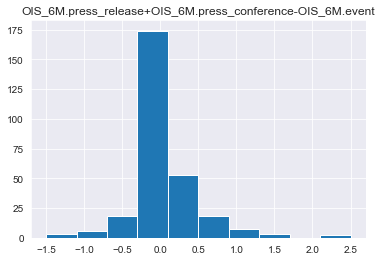

In [12]:
plt.hist(ois6m_df["event_check"])
plt.title("OIS_6M.press_release+OIS_6M.press_conference-OIS_6M.event")
plt.show()

The null hypothesis is that the OIS_6M change in the monetary event window is the sum of the change in the press release window and the press conference window, so,
$H_0 : \hat{\beta} = 0$

The test statistic = $\frac{\overline{x}}{std(x)}$

In [17]:
import scipy.stats as sc
tstat=ois6m_df["event_check"].mean()/ois6m_df["event_check"].std()
if sc.t.sf(tstat,ois6m_df.shape[0]-1)<0.01:
    print("Reject null hypothesis")
else:
    print("Accept null hypothesis")

Accept null hypothesis


Thus, with 99% confidence it can be accepted that the total change in the monetary event window is the sum of the change in the press release window and the press conference window.

In [33]:
#ois6m_df["DE10Y"]=dataog["Event"]["DE10Y"]
#ois6m_df["DE20Y"]=dataog["Event"]["DE20Y"]
#ois6m_df["DE30Y"]=dataog["Event"]["DE30Y"]
#ois6m_df["constant"]=1
#for yld in ["DE10Y","DE20Y","DE30Y"]:
#    mod = sm.OLS(ois6m_df["event"],ois6m_df[["constant",yld]])
#    print(mod.fit(cov_type="HC3").summary())

## Monetary Policy Event - Monthly

In [340]:
df = pd.read_csv("Belgiumdf.csv")
df.shape

(190, 9)

In [341]:
#the yield curve data is available from 2006-03 till 2022-12. 
#the ois data is available from 1999-01 to 2021-12
#the macro data is available from 1965-01 to 2022-10

#the intersection dataset is 2006-03 to 2021-12, that is, 10+(12*15)=190 monthly observations

In [342]:
df["log_cpi"]=np.log(df["cpi"]) #taking logarithms
df["log_indus"]=np.log(df["indus_index"])
df["lag_ix"]=189-df["Unnamed: 0"]
df.drop("Unnamed: 0",axis=1,inplace=True)
df=df.sort_values(by="lag_ix").reset_index(drop=True)# setting up a column of lags, recent observation is 2021-12
df["constant"]=1

In [343]:
df.head()

,Calendar_Month,unemp_rate,indus_index,cpi,OIS_6M_x,Event_Count,1Y_Bond_Yield,OIS_6M,log_cpi,log_indus,lag_ix,constant
0,2021-12,5.6,128.1,115.93,-0.275001,1,-0.00702,-0.275001,4.752987,4.852811,0,1
1,2021-11,5.8,125.4,115.95,-0.139999,0,-0.00779,0.000000,4.753159,4.831509,1,1
2,2021-10,6.0,132.2,114.33,-0.139999,1,-0.00664,-0.139999,4.739089,4.884316,2,1
3,2021-09,6.2,129.5,112.35,-0.030002,1,-0.00681,-0.030002,4.721619,4.863681,3,1
4,2021-08,6.3,131.1,112.41,-0.070000,0,-0.00685,0.000000,4.722153,4.875960,4,1


The index year for the harmonised consumer price index and the index of industrial production is 2015

------------------------------------------Standardised Variables of Interest--------------------------------------------


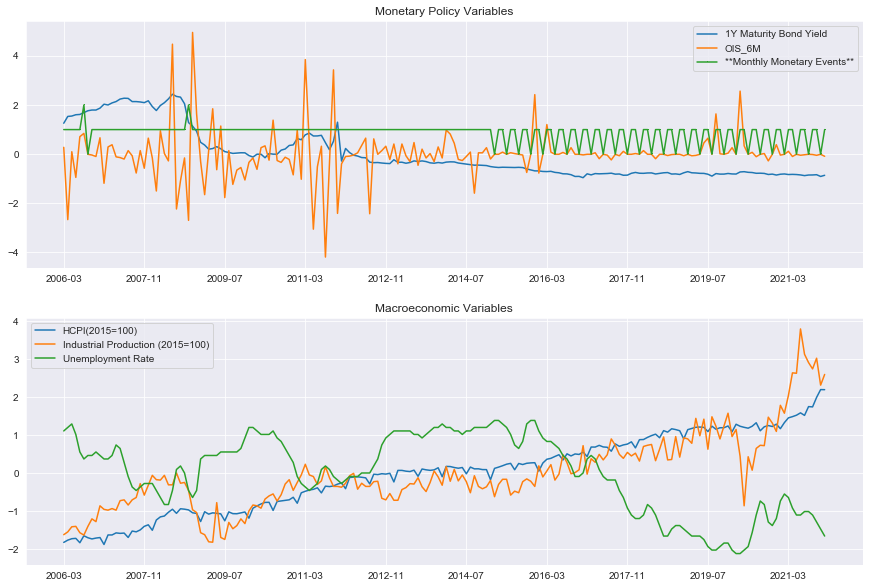

In [21]:
dfplot=df.sort_values(by="Calendar_Month")
fig,ax=plt.subplots(2,1,figsize=(15,10))
print("------------------------------------------Standardised Variables of Interest--------------------------------------------")
ax[0].plot(dfplot["Calendar_Month"],(dfplot["1Y_Bond_Yield"]-dfplot["1Y_Bond_Yield"].mean())/dfplot["1Y_Bond_Yield"].std(),label="1Y Maturity Bond Yield")
ax[0].plot(dfplot["Calendar_Month"],(dfplot["OIS_6M"]-dfplot["OIS_6M"].mean())/dfplot["OIS_6M"].std(),label="OIS_6M")
ax[0].plot(dfplot["Calendar_Month"],dfplot["Event_Count"],label="**Monthly Monetary Events**",marker=",")
ax[0].legend()
ax[0].xaxis.set_major_locator(ticker.MultipleLocator(20))
ax[0].title.set_text("Monetary Policy Variables")
ax[1].plot(dfplot["Calendar_Month"],(dfplot["cpi"]-dfplot["cpi"].mean())/dfplot["cpi"].std(),label="HCPI(2015=100)")
ax[1].plot(dfplot["Calendar_Month"],(dfplot["indus_index"]-dfplot["indus_index"].mean())/dfplot["indus_index"].std(),label="Industrial Production (2015=100)")
ax[1].plot(dfplot["Calendar_Month"],(dfplot["unemp_rate"]-dfplot["unemp_rate"].mean())/dfplot["unemp_rate"].std(),label="Unemployment Rate")
ax[1].legend()
ax[1].xaxis.set_major_locator(ticker.MultipleLocator(20))
ax[1].title.set_text("Macroeconomic Variables")
plt.show()

In [351]:
class lags_and_projections:
    
    def create_oisdf(self):
        self.oisdf=pd.DataFrame({k:[np.nan]*self.df.shape[0] for k in self.lag_list})
        self.oisdf["lag=0"]=self.df[self.exog_var]
        self.oisdf["Calendar_Month"]=self.df["Calendar_Month"]
        for q in range(self.x_lags-1):
            self.oisdf["lag="+str(q+1)]=list(self.df[(q+1):][self.exog_var])+[np.nan]*(q+1)
        self.oisdf.dropna(inplace=True)
        return self.oisdf
    
    def create_df(self):
        oisdftemp=self.create_oisdf()
        self.reg_df=pd.merge(oisdftemp,self.df[["Calendar_Month",self.endog_var]+self.endog_lags],on="Calendar_Month",how="inner")
        self.reg_df["constant"]=1
        return self.reg_df
    
    def distributed_lag(self,give_betas=False,give_plot=False,give_summary=False,give_data=False):
        #print("Selected Model: Distributed Lag")
        #self.endog_var=endog_var
        #self.oisdf=self.create_df()
        #reg_df=pd.merge(self.oisdf,self.df[["Calendar_Month",self.endog_var]+self.endog_lags],on="Calendar_Month",how="inner")
        #reg_df["constant"]=1
        reg_df=self.create_df()
        if give_data==True:
            return reg_df
        olsmodel=sm.OLS(reg_df[self.endog_var],reg_df[["constant"]+self.lag_list+self.endog_lags])
        self.olsmodel=olsmodel.fit()
        if self.n_lags==0:
            self.betas_dl=list(self.olsmodel.params[1:])
        if self.n_lags>0:
            self.betas_dl=list(self.olsmodel.params[1:-self.n_lags]) #last two coefficients are on lagged endogenous variables
        if give_betas==True:
            return self.betas_dl
        if give_summary==True:
            return self.olsmodel.summary()
        
    def local_projection(self,opt="Linear",give_betas=False,give_plot=False,give_data=False):
        #print("Selected Model: "+opt+" Local Projection")
        reg_df=self.create_df()
        self.betas_lp=[]
        if give_data==True:
            return reg_df
        for h in range(self.x_lags):
            y=reg_df[[self.endog_var]].head(reg_df.shape[0]-h).reset_index(drop=True) #the future projection values
            x=reg_df[["constant","lag=0"]+self.endog_lags].loc[h:].reset_index(drop=True) #the past of the exog_var
            mod=sm.OLS(y,x)
            mod=mod.fit()
            self.betas_lp.append(mod.params[1])
        if give_betas==True:
            return list(self.betas_lp)
        if give_summary==True:
            return self.olsmodel.summary()
        
    def __init__(self,endog_var,n_lags=0,x_lags=24,df=df,exog_var="OIS_6M"):
        self.x_lags=x_lags+1
        self.n_lags=n_lags
        self.exog_var,self.endog_var=exog_var,endog_var
        self.endog_lags=[]
        self.df=df
        if n_lags==0:
            self.df=df
        elif self.n_lags>0:
            for i in range(self.n_lags):
                lx=self.endog_var+"-"+str(i+1)
                self.endog_lags.append(lx)
                df[lx]=list(df[self.endog_var][i+1:])+[np.nan]*(i+1)
            self.df=df
        self.lag_list = ["lag="+str(q) for q in range(self.x_lags)]
        self.betas=[]

In [352]:
p,q=0,24 ### enter p,q for endogenous and exogenous lags

In [354]:
def dual_plots(ser_lp,ser_dl,endog_var,lags=(p,q)):
    endog_var_dict={"unemp_rate":"Unemployment Rate",
                   "log_cpi":"Log CPI Index(base=2015)",
                   "log_indus":"Log Industrial Activity Index(base=2015)",
                   "1Y_Bond_Yield":"1Y Maturity Bond Yield"}
    print("**************Impulse Response Functions for "+endog_var_dict[endog_var]+"**************")
    print("---- Endogenous Variable Lags = "+str(lags[0])+"  ----  "+"Exogenous Variable Lags = "+str(lags[1])+" ----")
    fig,ax=plt.subplots(1,2,figsize=(16,4))
    ax[0].plot(ser_dl)
    ax[0].title.set_text("**Distributed Lag Model**")
    ax[1].plot(ser_lp)
    ax[1].title.set_text("**Local Linear Projection Model**")
    plt.show()
    plt.close()

endog_var_x = ["unemp_rate","log_indus","log_cpi","1Y_Bond_Yield"]

**************Impulse Response Functions for Unemployment Rate**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 24 ----


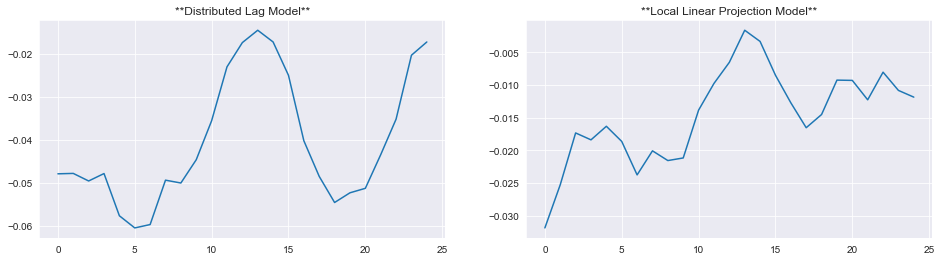

**************Impulse Response Functions for Log Industrial Activity Index(base=2015)**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 24 ----


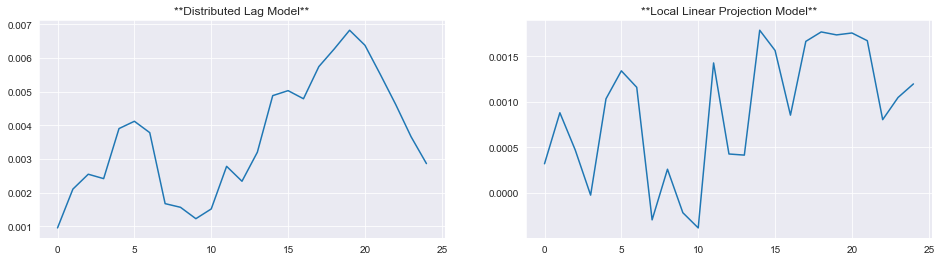

**************Impulse Response Functions for Log CPI Index(base=2015)**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 24 ----


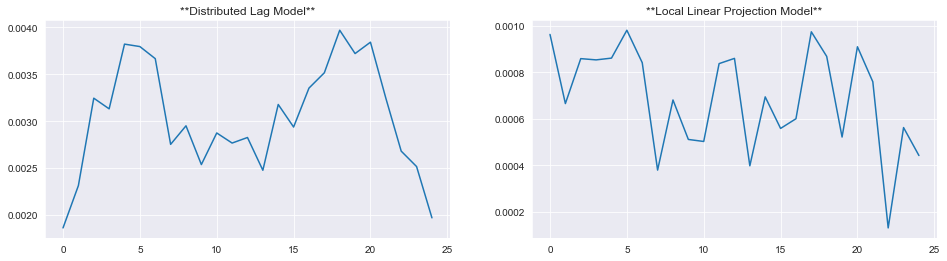

**************Impulse Response Functions for 1Y Maturity Bond Yield**************
---- Endogenous Variable Lags = 0  ----  Exogenous Variable Lags = 24 ----


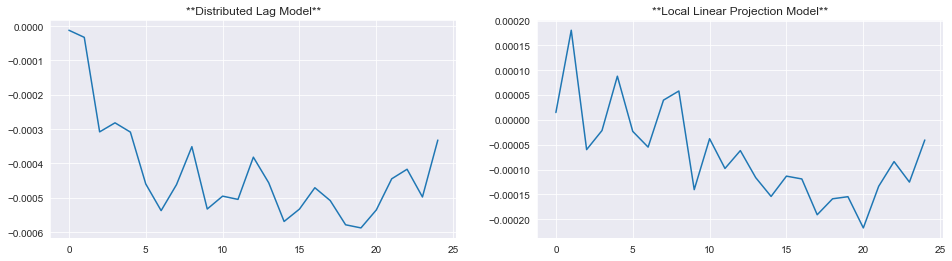

In [355]:
for var in endog_var_x:
    method=lags_and_projections(endog_var=var,n_lags=p,x_lags=q)
    dual_plots(ser_dl=method.distributed_lag(give_betas=True),ser_lp=method.local_projection(give_betas=True),endog_var=var)

**************Impulse Response Functions for Unemployment Rate**************
---- Endogenous Variable Lags = 1  ----  Exogenous Variable Lags = 24 ----


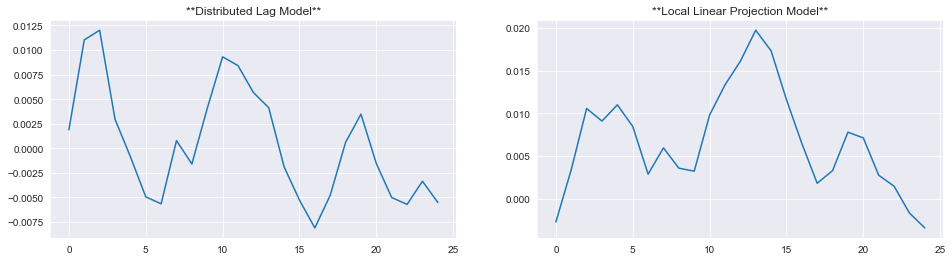

**************Impulse Response Functions for Log Industrial Activity Index(base=2015)**************
---- Endogenous Variable Lags = 1  ----  Exogenous Variable Lags = 24 ----


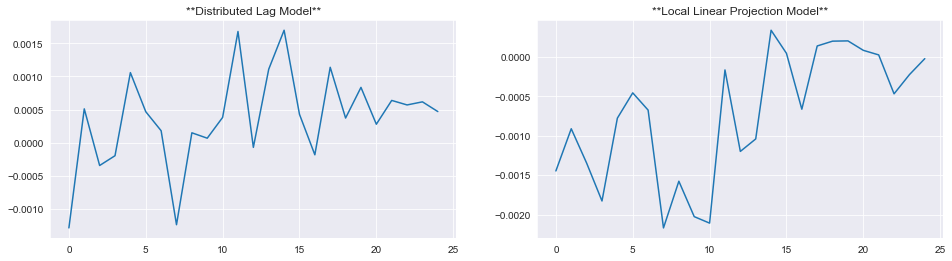

**************Impulse Response Functions for Log CPI Index(base=2015)**************
---- Endogenous Variable Lags = 1  ----  Exogenous Variable Lags = 24 ----


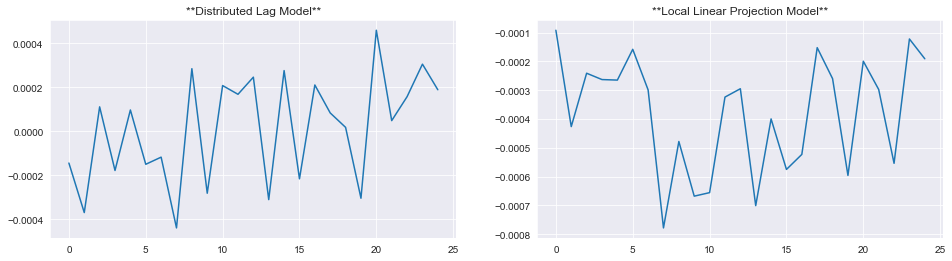

**************Impulse Response Functions for 1Y Maturity Bond Yield**************
---- Endogenous Variable Lags = 1  ----  Exogenous Variable Lags = 24 ----


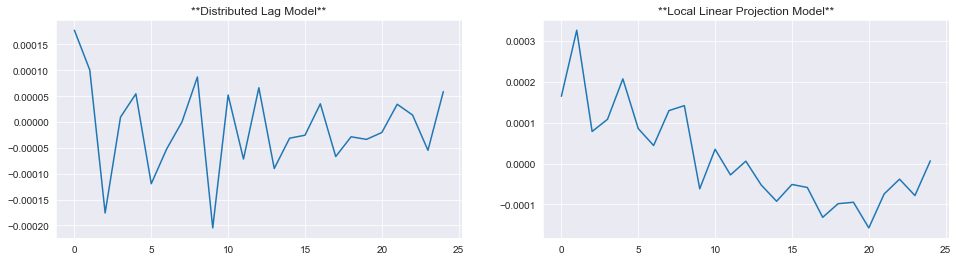

In [357]:
p=1
for var in endog_var_x:
    method=lags_and_projections(endog_var=var,n_lags=p,x_lags=q)
    dual_plots(ser_dl=method.distributed_lag(give_betas=True),ser_lp=method.local_projection(give_betas=True),endog_var=var,lags=(p,q))

**************Impulse Response Functions for Unemployment Rate**************
---- Endogenous Variable Lags = 2  ----  Exogenous Variable Lags = 24 ----


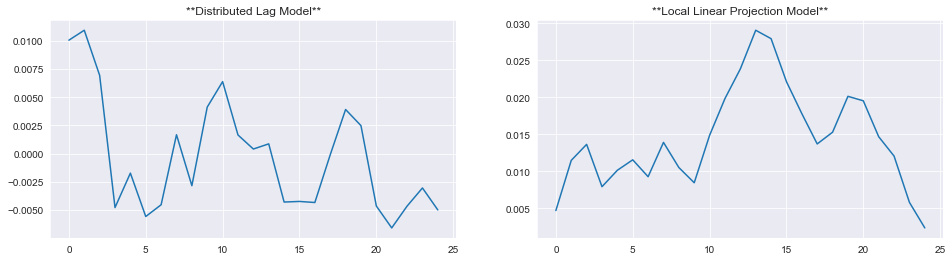

**************Impulse Response Functions for Log Industrial Activity Index(base=2015)**************
---- Endogenous Variable Lags = 2  ----  Exogenous Variable Lags = 24 ----


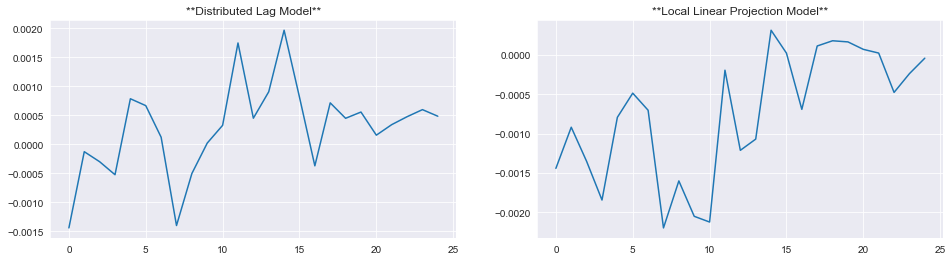

**************Impulse Response Functions for Log CPI Index(base=2015)**************
---- Endogenous Variable Lags = 2  ----  Exogenous Variable Lags = 24 ----


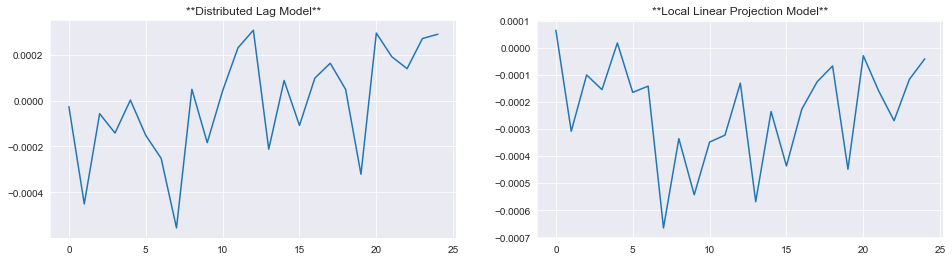

**************Impulse Response Functions for 1Y Maturity Bond Yield**************
---- Endogenous Variable Lags = 2  ----  Exogenous Variable Lags = 24 ----


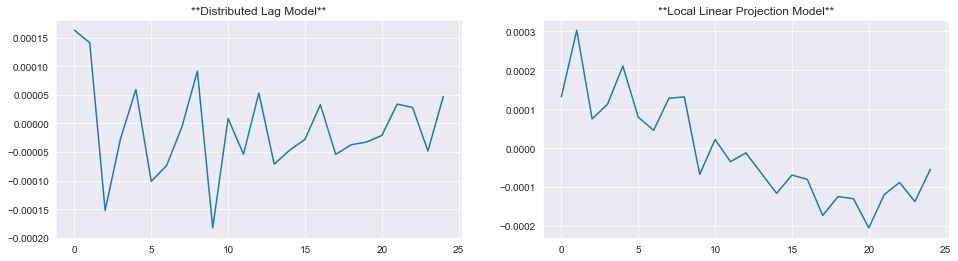

In [359]:
p=2
for var in endog_var_x:
    method=lags_and_projections(endog_var=var,n_lags=p,x_lags=q)
    dual_plots(ser_dl=method.distributed_lag(give_betas=True),ser_lp=method.local_projection(give_betas=True),endog_var=var,lags=(p,q))

# END OF MAIN CODE 

In [251]:
df

,Calendar_Month,unemp_rate,indus_index,cpi,OIS_6M_x,Event_Count,1Y_Bond_Yield,OIS_6M,log_cpi,log_indus,lag_ix,constant,log_cpi-1
0,2021-12,5.6,128.1,115.93,-0.275001,1,-0.00702,-0.275001,4.752987,4.852811,0,1,4.753159
1,2021-11,5.8,125.4,115.95,-0.139999,0,-0.00779,0.000000,4.753159,4.831509,1,1,4.739089
2,2021-10,6.0,132.2,114.33,-0.139999,1,-0.00664,-0.139999,4.739089,4.884316,2,1,4.721619
3,2021-09,6.2,129.5,112.35,-0.030002,1,-0.00681,-0.030002,4.721619,4.863681,3,1,4.722153
4,2021-08,6.3,131.1,112.41,-0.070000,0,-0.00685,0.000000,4.722153,4.875960,4,1,4.705739
...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,2006-07,8.0,88.1,84.09,2.400000,1,0.03296,2.400000,4.431888,4.478473,185,1,4.442651
186,2006-06,8.5,89.7,85.00,-3.150000,1,0.03278,-3.150000,4.442651,4.496471,186,1,4.441827
187,2006-05,8.8,89.6,84.93,0.350000,1,0.03192,0.350000,4.441827,4.495355,187,1,4.438289
188,2006-04,8.7,88.3,84.63,-8.900000,1,0.03166,-8.900000,4.438289,4.480740,188,1,4.432720


In [171]:
df["1Y_Bond_Yield"]=df["1Y_Bond_Yield"]*100

In [172]:
endog_var = ["unemp_rate","log_indus","log_cpi","1Y_Bond_Yield"]
exog_var = ["constant","OIS_6M"]
lag_list = ["lag="+str(q) for q in range(25)]

In [252]:
#creating the lag df of ois_6m
oisdf=pd.DataFrame({k:[np.nan]*df.shape[0] for k in lag_list})
oisdf["lag=0"]=df["OIS_6M"]
oisdf["Calendar_Month"]=df["Calendar_Month"]
for q in range(24):
    oisdf["lag="+str(q+1)]=list(df[(q+1):]["OIS_6M"])+[np.nan]*(q+1)
oisdf

,lag=0,lag=1,lag=2,lag=3,lag=4,lag=5,lag=6,lag=7,lag=8,lag=9,...,lag=16,lag=17,lag=18,lag=19,lag=20,lag=21,lag=22,lag=23,lag=24,Calendar_Month
0,-0.275001,0.000000,-0.139999,-0.030002,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,...,0.000000,-0.330001,0.270000,0.000000,1.150000,8.605003,0.000000,0.900000,0.150001,2021-12
1,0.000000,-0.139999,-0.030002,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,0.000000,...,-0.330001,0.270000,0.000000,1.150000,8.605003,0.000000,0.900000,0.150001,0.000000,2021-11
2,-0.139999,-0.030002,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,0.000000,-0.115001,...,0.270000,0.000000,1.150000,8.605003,0.000000,0.900000,0.150001,0.000000,0.070000,2021-10
3,-0.030002,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,0.000000,-0.115001,1.310000,...,0.000000,1.150000,8.605003,0.000000,0.900000,0.150001,0.000000,0.070000,5.499998,2021-09
4,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,0.000000,-0.115001,1.310000,0.000000,...,1.150000,8.605003,0.000000,0.900000,0.150001,0.000000,0.070000,5.499998,0.000000,2021-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,2.400000,-3.150000,0.350000,-8.900000,0.950000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-07
186,-3.150000,0.350000,-8.900000,0.950000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-06
187,0.350000,-8.900000,0.950000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-05
188,-8.900000,0.950000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2006-04


In [253]:
oisdf.dropna(inplace=True)

In [254]:
oisdf

,lag=0,lag=1,lag=2,lag=3,lag=4,lag=5,lag=6,lag=7,lag=8,lag=9,...,lag=16,lag=17,lag=18,lag=19,lag=20,lag=21,lag=22,lag=23,lag=24,Calendar_Month
0,-0.275001,0.000000,-0.139999,-0.030002,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,...,0.000000,-0.330001,0.270000,0.000000,1.150000,8.605003,0.000000,0.900000,0.150001,2021-12
1,0.000000,-0.139999,-0.030002,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,0.000000,...,-0.330001,0.270000,0.000000,1.150000,8.605003,0.000000,0.900000,0.150001,0.000000,2021-11
2,-0.139999,-0.030002,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,0.000000,-0.115001,...,0.270000,0.000000,1.150000,8.605003,0.000000,0.900000,0.150001,0.000000,0.070000,2021-10
3,-0.030002,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,0.000000,-0.115001,1.310000,...,0.000000,1.150000,8.605003,0.000000,0.900000,0.150001,0.000000,0.070000,5.499998,2021-09
4,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,0.000000,-0.115001,1.310000,0.000000,...,1.150000,8.605003,0.000000,0.900000,0.150001,0.000000,0.070000,5.499998,0.000000,2021-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,-7.450000,15.000000,-0.900000,0.100000,3.200000,-5.000000,-0.500000,2.200000,-1.900000,0.500000,...,1.300000,1.000000,-3.950000,2.250000,-0.300000,-0.100000,0.000000,2.850000,2.400000,2008-07
162,15.000000,-0.900000,0.100000,3.200000,-5.000000,-0.500000,2.200000,-1.900000,0.500000,-2.550000,...,1.000000,-3.950000,2.250000,-0.300000,-0.100000,0.000000,2.850000,2.400000,-3.150000,2008-06
163,-0.900000,0.100000,3.200000,-5.000000,-0.500000,2.200000,-1.900000,0.500000,-2.550000,-0.200000,...,-3.950000,2.250000,-0.300000,-0.100000,0.000000,2.850000,2.400000,-3.150000,0.350000,2008-05
164,0.100000,3.200000,-5.000000,-0.500000,2.200000,-1.900000,0.500000,-2.550000,-0.200000,0.500000,...,2.250000,-0.300000,-0.100000,0.000000,2.850000,2.400000,-3.150000,0.350000,-8.900000,2008-04


The distributed lag model is given by $y_t = \alpha + \sum_{i=0}^{q} \beta_{i} x_{t-i} + \epsilon_t$ and the impulse response formulation of this model is given by, $y_t = \alpha + \beta (L)x_t + u_t$, and the impulse response is captured by $\beta (L)$. 

In [176]:
#variables for IRF matrix
n_lags,time_shock=25,10 #time of shock starting from t=0
shock_val=1.10
N=df.shape[0]

In [177]:
#the time for shock can be any period from -1 to -166
#reg_df=pd.merge(oisdf,df[["Calendar_Month","log_cpi"]],on="Calendar_Month",how="inner")
#reg_df["constant"]=1
#reg_df=reg_df.sort_values(by="Calendar_Month")
#reg_df

## Distributed Lag Model

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


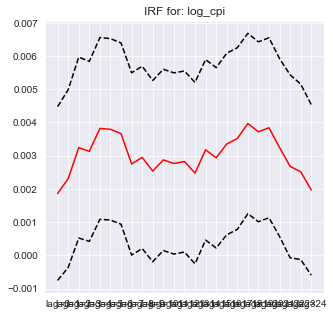

In [261]:
ols,ix={},0
fig,ax=plt.subplots(figsize=(5,5))
for var in ["log_cpi"]:
    reg_df=pd.merge(oisdf,df[["Calendar_Month",var,var+"-1"]],on="Calendar_Month",how="inner")
    #oisdf.dropna(inplace=True)
    reg_df["constant"]=1
    #reg_df=reg_df.sort_values(by="Calendar_Month")
    olsmodel=sm.OLS(reg_df[var],reg_df[["constant"]+lag_list])
    ols[var]=olsmodel.fit()
    
    ##Using the lecture notes: The series of parameters beta_0, beta_1,... beta_24 
    ##is the impulse response of y_t to a one time change in x_t
    #ax[ix].plot(range(len(yhat)),yhat)
    ax.plot(range(25),ols[var].params[1:],"r")
    ax.plot(ols[var].conf_int(alpha=0.1)[0][1:],"k--")
    ax.plot(ols[var].conf_int(alpha=0.1)[1][1:],"k--")
    ax.title.set_text("IRF for: "+var)
    ix=ix+1
    


In [262]:
reg_df

,lag=0,lag=1,lag=2,lag=3,lag=4,lag=5,lag=6,lag=7,lag=8,lag=9,...,lag=19,lag=20,lag=21,lag=22,lag=23,lag=24,Calendar_Month,log_cpi,log_cpi-1,constant
0,-0.275001,0.000000,-0.139999,-0.030002,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,...,0.000000,1.150000,8.605003,0.000000,0.900000,0.150001,2021-12,4.752987,4.753159,1
1,0.000000,-0.139999,-0.030002,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,0.000000,...,1.150000,8.605003,0.000000,0.900000,0.150001,0.000000,2021-11,4.753159,4.739089,1
2,-0.139999,-0.030002,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,0.000000,-0.115001,...,8.605003,0.000000,0.900000,0.150001,0.000000,0.070000,2021-10,4.739089,4.721619,1
3,-0.030002,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,0.000000,-0.115001,1.310000,...,0.000000,0.900000,0.150001,0.000000,0.070000,5.499998,2021-09,4.721619,4.722153,1
4,0.000000,-0.070000,-0.129998,0.000000,-0.299999,0.409999,0.000000,-0.115001,1.310000,0.000000,...,0.900000,0.150001,0.000000,0.070000,5.499998,0.000000,2021-08,4.722153,4.705739,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,-7.450000,15.000000,-0.900000,0.100000,3.200000,-5.000000,-0.500000,2.200000,-1.900000,0.500000,...,2.250000,-0.300000,-0.100000,0.000000,2.850000,2.400000,2008-07,4.502140,4.511519,1
162,15.000000,-0.900000,0.100000,3.200000,-5.000000,-0.500000,2.200000,-1.900000,0.500000,-2.550000,...,-0.300000,-0.100000,0.000000,2.850000,2.400000,-3.150000,2008-06,4.511519,4.504576,1
163,-0.900000,0.100000,3.200000,-5.000000,-0.500000,2.200000,-1.900000,0.500000,-2.550000,-0.200000,...,-0.100000,0.000000,2.850000,2.400000,-3.150000,0.350000,2008-05,4.504576,4.495913,1
164,0.100000,3.200000,-5.000000,-0.500000,2.200000,-1.900000,0.500000,-2.550000,-0.200000,0.500000,...,0.000000,2.850000,2.400000,-3.150000,0.350000,-8.900000,2008-04,4.495913,4.493903,1


## Local Linear Projection Model

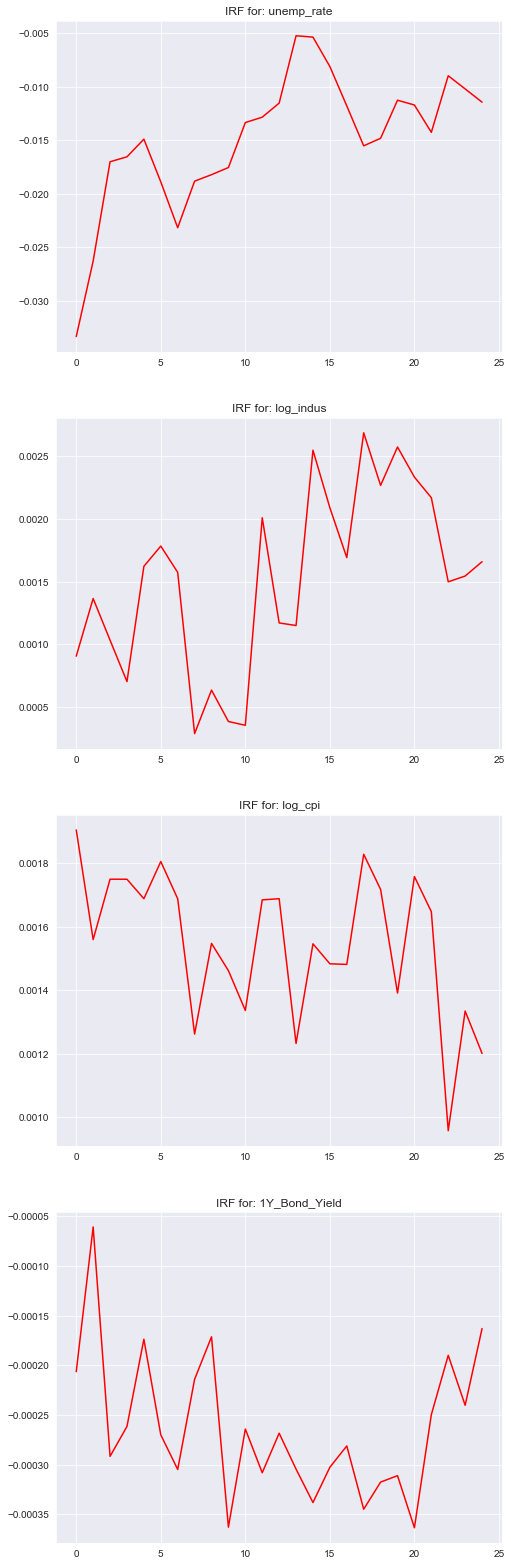

In [263]:
fig,ax=plt.subplots(4,1,figsize=(8,28))
ix=0
for var in endog_var:
    betas=[]
    betas_u=[]
    betas_l=[]
    lag_list=["lag="+str(x) for x in range(25)]
    for h in range(25):
        y=df[[var]].head(df.shape[0]-h).reset_index(drop=True)
        x=df[["constant","OIS_6M"]].loc[h:].reset_index(drop=True)
        mod=sm.OLS(y,x)
        mod=mod.fit()
        betas.append(mod.params[1])
        betas_u.append(mod.conf_int(alpha=0.05)[1][1])
        betas_l.append(mod.conf_int(alpha=0.05)[0][1])
    ax[ix].plot(range(25),betas,"r")
    ax[ix].title.set_text("IRF for: "+var)
    #ax[ix].plot(lag_list,betas_u,"k--")
    #ax[ix].plot(lag_list,betas_l,"k--")
    ix=ix+1

In [90]:
np.mean(betas)+1.64*np.std(betas)/np.sqrt(166)

-0.00025358824700154445

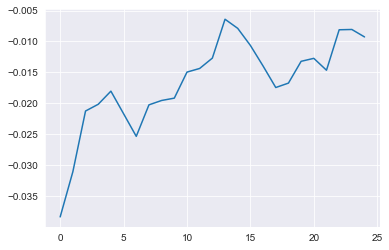

In [74]:
plt.plot(betas)

## APPENDIX: DATA PREPARATION

In [94]:
dataog['Event']['Calendar_Month'] = dataog['Event']['date'].apply(lambda x: str(x)[:7]) #removes the date and keeps only yyyy-mm
ois6m = dataog['Event'][['Calendar_Month','OIS_6M']].groupby('Calendar_Month').sum().reset_index() #the net monthly change in the OIS_6M
ois6m["Event_Count"]=dataog['Event'][['Calendar_Month','OIS_6M']].groupby('Calendar_Month').count().reset_index()["OIS_6M"] #the total number of events in OIS_6M in a  month

In [110]:
ois6m["yeardd"]=ois6m["Calendar_Month"].apply(lambda x: int(x.split("-")[0])*100+int(x.split("-")[1]))

In [96]:
ois6m[ois6m["yeardd"]>=200603]

,Calendar_Month,OIS_6M,Event_Count,yeardd
85,2006-03,0.950000,1,200603
86,2006-04,-8.900000,1,200604
87,2006-05,0.350000,1,200605
88,2006-06,-3.150000,1,200606
89,2006-07,2.400000,1,200607
...,...,...,...,...
241,2021-06,-0.129998,1,202106
242,2021-07,-0.070000,1,202107
243,2021-09,-0.030002,1,202109
244,2021-10,-0.139999,1,202110


Developing the country wide dataset: 

1. The consumer prices

2. The industrial production

3. The unemployment rate


In [101]:
date_list=[str(2006+yy)+"-0"+str(mm+1) for yy in range(16) for mm in range(9) ]+[str(2006+yy)+"-"+str(mm+10) for yy in range(16) for mm in range(3)]
date_list=sorted(date_list)[2:]

In [103]:
#date_list

In [44]:
#preparing the unemployment rate and the industrial production index data

macrodf = pd.read_excel("data_prep.xlsx",sheet_name="new_data")
macrodf.dropna(inplace=True)
macrodf["Calendar_Month"]=date_list+[np.nan]*(macrodf.shape[0]-len(date_list))
macrodf.dropna(inplace=True)

In [46]:
macrodf

,unemp_rate,indus_index,Calendar_Month
0,8.6,87.6,2006-03
2,8.7,88.3,2006-04
4,8.8,89.6,2006-05
6,8.5,89.7,2006-06
8,8,88.1,2006-07
...,...,...,...
370,6.3,131.1,2021-08
372,6.2,129.5,2021-09
374,6,132.2,2021-10
376,5.8,125.4,2021-11


In [125]:
#adding the harmonised consumer price index
macro_df = pd.merge(macrodf,pd.read_excel("data_prep.xlsx",sheet_name="inflation_data"),on="Calendar_Month",how="inner")

In [129]:
macro_df.dropna(inplace=True)

In [130]:
macro_df

,unemp_rate,indus_index,Calendar_Month,cpi
0,8.6,87.6,2006-03,84.16
1,8.7,88.3,2006-04,84.63
2,8.8,89.6,2006-05,84.93
3,8.5,89.7,2006-06,85.00
4,8,88.1,2006-07,84.09
...,...,...,...,...
185,6.3,131.1,2021-08,112.41
186,6.2,129.5,2021-09,112.35
187,6,132.2,2021-10,114.33
188,5.8,125.4,2021-11,115.95


In [111]:
oiszeros = pd.DataFrame({"Calendar_Month":date_list,
                        "OIS_6M":[np.nan]*len(date_list),
                        "Event_Count":[0]*len(date_list)
                        })
ois6m=ois6m[ois6m["yeardd"]>=200603]
ois6m=ois6m[ois6m["yeardd"]<202200]
ois6m.drop("yeardd",axis=1,inplace=True)

In [112]:
ois6m

,Calendar_Month,OIS_6M,Event_Count
85,2006-03,0.950000,1
86,2006-04,-8.900000,1
87,2006-05,0.350000,1
88,2006-06,-3.150000,1
89,2006-07,2.400000,1
...,...,...,...
241,2021-06,-0.129998,1
242,2021-07,-0.070000,1
243,2021-09,-0.030002,1
244,2021-10,-0.139999,1


In [113]:
ois6mdf=pd.merge(ois6m,oiszeros,on="Calendar_Month",how="outer").sort_values(by="Calendar_Month")
ois6mdf["OIS_6M_x"].fillna(0,inplace=True)
ois6mdf["Event_Count_x"].fillna(0,inplace=True)
ois6mdf["Event_Count"]=(ois6mdf["Event_Count_x"]+ois6mdf["Event_Count_y"]).astype(int)
ois6mdf["OIS_6M"]=ois6mdf["OIS_6M_x"]

In [114]:
ois6mdf

,Calendar_Month,OIS_6M_x,Event_Count_x,OIS_6M_y,Event_Count_y,Event_Count,OIS_6M
0,2006-03,0.950000,1.0,NaN,0,1,0.950000
1,2006-04,-8.900000,1.0,NaN,0,1,-8.900000
2,2006-05,0.350000,1.0,NaN,0,1,0.350000
3,2006-06,-3.150000,1.0,NaN,0,1,-3.150000
4,2006-07,2.400000,1.0,NaN,0,1,2.400000
...,...,...,...,...,...,...,...
188,2021-08,0.000000,0.0,NaN,0,0,0.000000
158,2021-09,-0.030002,1.0,NaN,0,1,-0.030002
159,2021-10,-0.139999,1.0,NaN,0,1,-0.139999
189,2021-11,0.000000,0.0,NaN,0,0,0.000000


In [ ]:
lag_cols=["lag_0"+str(i) for i in range(24)]
df[lag_cols]=0

In [38]:
X = [list(df["unemp_rate"])]*df.shape[0]

In [39]:
np.matrix(X).shape

(190, 190)

In [33]:
np.matrix(dl_mat).shape

(167, 190)

In [115]:
ois6mdf=ois6mdf[["Calendar_Month","OIS_6M","Event_Count"]]

In [131]:
#adding the ois6m data
macro_ois_df=pd.merge(macro_df,ois6mdf,on="Calendar_Month",how="inner")

In [98]:
yields_history=[]
#adding the 1year bond maturity
for ix in range(11):
    yieldURL = "https://www.marketwatch.com/investing/bond/tmbmkbe-01y/downloaddatapartial?partial=true&index="+str(ix)+"&countryCode=bx&iso=&startDate=01%2F03%2F2000%2000%3A00%3A00&endDate=12%2F23%2F2022%2000%3A00%3A00&frequency=P1M&downloadPartial=true&csvDownload=false&newDates=false"
    url = yieldURL
    html = urlopen(url).read()
    soup = BeautifulSoup(html, features="html.parser")
    page_text = [x.split("\n\n\n") for x in soup.get_text().split("\n\n\n\n\n")[2:-1]][0]
    yields = [y.split("\n")[1]+","+y.split("\n")[-1] for y in page_text]
    yields_history = yields_history+yields

In [104]:
yields_history=yields_history[12:]

In [120]:
yielddf = {"Calendar_Month":[str(x.split(",")[0].split("/")[1])+"-"+str(x.split(",")[0].split("/")[0]) for x in yields_history],
          "1Y_Bond_Yield":[float(x.split(",")[1].replace("%",""))/100 for x in yields_history]
          }#bond yield/100

In [132]:
macro_ois_1y_df=pd.merge(macro_ois_df,pd.DataFrame(yielddf),on="Calendar_Month",how="inner")

In [134]:
belgium_df = macro_ois_1y_df[["Calendar_Month","unemp_rate","indus_index","cpi","OIS_6M","Event_Count","1Y_Bond_Yield"]]

In [135]:
belgium_df.to_csv("BelgiumDf.csv")

Scrap Code

testdf["Event_Count_y"].fillna(0,inplace=True)
testdf["Event_Count_x"].fillna(0,inplace=True)
testdf["Event_Count"] = (testdf["Event_Count_x"]+testdf["Event_Count_y"]).astype(int)
testdf["OIS_6M"] = testdf["OIS_6M_y"].fillna(method="ffill")
finaldf = testdf[['Calendar_Month',
                  'Bond_Yield',
                  'Unemployment_Rate',
                  'CPI',
                  'Industrial_Production_Index',
                  'OIS_6M',
                  'Event_Count']]
finaldf.dropna(inplace=True)
finaldf = pd.merge(macrodf,oiszeros,on="Calendar_Month",how="outer")
#finaldf = pd.merge(finaldf,ois6m,on="Calendar_Month",how="inner")
print(finaldf.head())
print("-----")
print(finaldf.shape)

    #betas_shocks=makeIRF(n_lags).dot(np.matrix(list(ols[var].params)[1:]).T)
    #irf=c+betas_shocks
    #irf=[irf[i,0] for i in range(irf.shape[0])]
    #usl=UnivariateSpline(range(len(irf)),irf,k=3)
    
    yhat=ols[var].predict()
    yshock=[c+ x for x in IRF_nomat(list(ols[var].params[1:]))]
    usl=UnivariateSpline(range(len(yshock)),yshock,k=4)
    time_units=range(len(yshock))
    #constant_l=ols[var].conf_int(alpha=0.05).loc["constant",0]
    #constant_u=ols[var].conf_int(alpha=0.05).loc["constant",1]


    l_bounds=[c+x for x in IRF_nomat(ols[var].conf_int(alpha=0.05)[0][1:])]
    #l_bounds=[l_bounds[i,0] for i in range(l_bounds.shape[0])]
    #usll=UnivariateSpline(range(len(irf)),l_bounds)
    #u_bounds=makeIRF(n_lags).dot(np.matrix(list(ols[var].conf_int(alpha=0.05)[1][1:])).T)+[c]*len(irf)
    u_bounds=[c+x for x in IRF_nomat(ols[var].conf_int(alpha=0.05)[1][1:])]
    #uslu=UnivariateSpline(range(len(irf)),u_bounds)
    
    #ax[ix].plot(range(len(yshock)),usl(time_units),color='red',label="spline")
    #ax[ix].plot(time_units,usll(time_units),color='black')
    #ax[ix].plot(time_units,uslu(time_units),color='black')

    #ax[ix].plot(range(len(yshock)),l_bounds)
    #ax[ix].plot(range(len(yshock)),u_bounds)
    #ax[ix].plot([166-150]*len(irf),irf)
    #ax[ix].set_ylim(c-0.03,c+0.03)


def makeIRF(lags,shock_val=1.1,total_periods=oisdf.shape[0],time_shock=150):
    irf_mat=np.ones((total_periods,lags))
    #shock_start=int(time_shock/lags)-1
    #if time_shock%lags==0: lag_start=24
    #else: lag_start=(time_shock%lags)-1
    #print(shock_start)
    #print(lag_start)
    start_ix=total_periods-(time_shock+lags)
    for i in range(lags):
        irf_mat[start_ix+i][lags-1-i]=shock_val
        #shock_start=shock_start-1
    return np.matrix(irf_mat)

In [14]:
def IRF_nomat(betas):
    n_q=len(betas)
    first=[sum(betas)]*(time_shock-1)
    shock=np.ones((n_q,n_q))+shock_val*np.eye(n_q)
    shock=shock.dot(betas).reshape(1,n_q).tolist()[0]
    end=[sum(betas)]*(N-n_q)
    return first+shock+end

In [119]:
df.drop("Unnamed: 0",axis=1,inplace=True)

In [118]:
ois6mdf

,Calendar_Month,OIS_6M,Event_Count
0,2006-03,0.950000,1
1,2006-04,-8.900000,1
2,2006-05,0.350000,1
3,2006-06,-3.150000,1
4,2006-07,2.400000,1
...,...,...,...
188,2021-08,0.000000,0
158,2021-09,-0.030002,1
159,2021-10,-0.139999,1
189,2021-11,0.000000,0


In [129]:
newdf=pd.merge(df,ois6mdf,on="Calendar_Month",how="inner")

In [130]:
newdf=newdf.rename(columns={"Event_Count_x":"Event_Count","OIS_6M_y":"OIS_6M"})

In [132]:
newdf.drop("Event_Count_y",axis=1,inplace=True)

In [135]:
newdf.to_csv("BelgiumDf.csv")

In [151]:
test=df.sort_values(by="lag_ix",ascending=False)

,Calendar_Month,unemp_rate,indus_index,cpi,OIS_6M_x,Event_Count,1Y_Bond_Yield,OIS_6M,log_cpi,log_indus,lag_ix,constant
189,2006-03,8.6,87.6,84.16,0.950000,1,2.718,0.950000,4.432720,4.472781,189,1
188,2006-04,8.7,88.3,84.63,-8.900000,1,3.166,-8.900000,4.438289,4.480740,188,1
187,2006-05,8.8,89.6,84.93,0.350000,1,3.192,0.350000,4.441827,4.495355,187,1
186,2006-06,8.5,89.7,85.00,-3.150000,1,3.278,-3.150000,4.442651,4.496471,186,1
185,2006-07,8.0,88.1,84.09,2.400000,1,3.296,2.400000,4.431888,4.478473,185,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4,2021-08,6.3,131.1,112.41,-0.070000,0,-0.685,0.000000,4.722153,4.875960,4,1
3,2021-09,6.2,129.5,112.35,-0.030002,1,-0.681,-0.030002,4.721619,4.863681,3,1
2,2021-10,6.0,132.2,114.33,-0.139999,1,-0.664,-0.139999,4.739089,4.884316,2,1
1,2021-11,5.8,125.4,115.95,-0.139999,0,-0.779,0.000000,4.753159,4.831509,1,1
